# Import Libraries

In [15]:
from FinancialMachineLearning.features.fracdiff import FractionalDifferentiatedFeatures
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import yfinance as yf
import ta

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Preprocess Datasets

In [18]:
start_date = '1962-01-01'
end_date = '2024-01-18'
ticker = 'XOM'

daily_train = yf.download(ticker, start_date, end_date)
daily_train.drop('Adj Close', axis = 1, inplace = True)

[*********************100%%**********************]  1 of 1 completed


# Add Features

### add fractionally differentiated features

In [3]:
def calculate_difference(df : pd.DataFrame, by : str = 'Close', end = 1, numbers = 11) :
    cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
    out = pd.DataFrame(columns = cols)
    for d in np.linspace(0, end, numbers):
        try:
            df1 = np.log(df).dropna()
            df2 = FractionalDifferentiatedFeatures.fracDiff(df1, d, thres = 1e-5)
            corr = np.corrcoef(df1.loc[df2.index, by], df2[by])[0,1]
            df2 = sm.tsa.stattools.adfuller(df2[by], maxlag = 1, regression = 'c', autolag = None)
            out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
        except Exception as e:
            print(f'd: {d}, error: {e}')
            continue
    return out

C:\Users\kim56\anaconda3\Find-A\MLFinLab\FinalProject\FinancialMachineLearning\features\fracdiff.py:54: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
C:\Users\kim56\anaconda3\Find-A\MLFinLab\FinalProject\FinancialMachineLearning\features\fracdiff.py:54: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
C:\Users\kim56\anaconda3\Find-A\MLFinLab\FinalProject\FinancialMachineLearning\features\fracdiff.py:54: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
C:\Users\kim56\anaconda3\Find-A\MLFinLab\FinalProject\FinancialMachineLearning\features\fracdiff.py:54: FutureWarning: The default dtype for empt

,adfStat,pVal,lags,nObs,95% conf,corr
0.00,-0.892083,7.905684e-01,1.0,14597.0,-2.861738,1.000000
0.05,-0.325455,9.218210e-01,1.0,4.0,-4.474365,0.999007
0.10,-0.381350,9.131663e-01,1.0,4.0,-4.474365,0.996126
0.15,-1.720336,4.206663e-01,1.0,6.0,-3.646238,0.984297
0.20,-1.707622,4.271898e-01,1.0,8.0,-3.367187,0.967079
0.25,-4.244201,5.541346e-04,1.0,13.0,-3.127149,0.932946
0.30,-3.615943,5.463453e-03,1.0,19.0,-3.031227,0.892474
0.35,-2.630868,8.678379e-02,1.0,30.0,-2.964071,0.898378
0.40,-3.103146,2.632127e-02,1.0,47.0,-2.925338,0.841688
0.45,-4.141121,8.275645e-04,1.0,75.0,-2.900925,0.704957


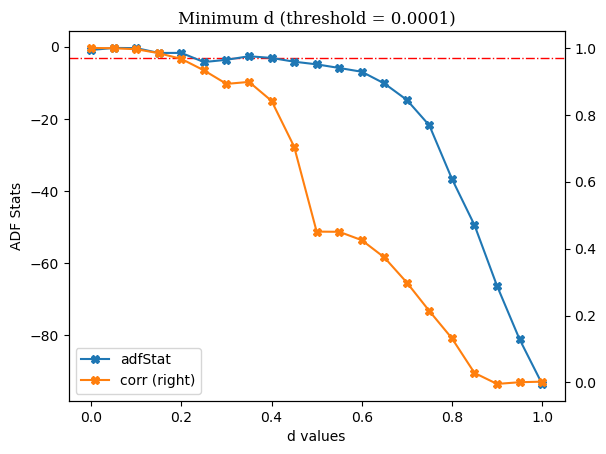

In [4]:
diff_res_close = calculate_difference(daily_train[['Close']], numbers = 21)

f,ax = plt.subplots()
ax.axhline(diff_res_close['95% conf'].mean(), lw = 1, color = 'r', ls = '-.')
diff_res_close[['adfStat', 'corr']].plot(ax = ax, marker = 'X', secondary_y = 'corr')
ax.set_title('Minimum d (threshold = 0.0001)', fontsize = 12, fontfamily = 'Serif')
ax.set_xlabel('d values')
ax.set_ylabel('ADF Stats')
ax.grid(False)
display(diff_res_close)

- $d=0.25$ 부근에서 adf 통계량 값이 95% 유의수준에서 유의하다. 따라서 $d=0.25$으로 결정

In [19]:
daily_train['Close_FD'] = FractionalDifferentiatedFeatures.fracDiff_FFD(daily_train[['Close']], 0.25)
daily_train

,Open,High,Low,Close,Volume,Close_FD
Date,,,,,,
1962-01-02,0.000000,1.589844,1.578125,1.578125,902400,NaN
1962-01-03,0.000000,1.601563,1.578125,1.601563,1200000,NaN
1962-01-04,0.000000,1.613281,1.597656,1.605469,1088000,NaN
1962-01-05,0.000000,1.613281,1.566406,1.570313,1222400,NaN
1962-01-08,0.000000,1.582031,1.546875,1.566406,1388800,NaN
...,...,...,...,...,...,...
2024-01-10,99.800003,99.800003,98.160004,98.690002,18206100,10.168887
2024-01-11,99.040001,99.500000,98.559998,98.669998,15833400,10.587538
2024-01-12,100.139999,100.650002,99.169998,99.949997,18032100,12.084669


In [5]:
diff_res_volume = calculate_difference(daily_train[['Volume']], by = 'Volume', numbers = 21)

f,ax = plt.subplots()
ax.axhline(diff_res_volume['95% conf'].mean(), lw = 1, color = 'r', ls = '-.')
diff_res_volume[['adfStat', 'corr']].plot(ax = ax, marker = 'X', secondary_y = 'corr')
ax.set_title('Minimum d', fontsize = 12, fontfamily = 'Serif')
ax.set_xlabel('d values')
ax.set_ylabel('ADF Stats')
ax.grid(False)
display(diff_res_volume)

KeyboardInterrupt: 

- $d=0.35$ 부근에서 adf 통계량 값이 95% 유의수준에서 유의하다. 따라서 $d=0.35$으로 결정

In [20]:
daily_train['Volume_FD'] = FractionalDifferentiatedFeatures.fracDiff_FFD(daily_train[['Volume']], 0.35)
daily_train

,Open,High,Low,Close,Volume,Close_FD,Volume_FD
Date,,,,,,,
1962-01-02,0.000000,1.589844,1.578125,1.578125,902400,NaN,NaN
1962-01-03,0.000000,1.601563,1.578125,1.601563,1200000,NaN,NaN
1962-01-04,0.000000,1.613281,1.597656,1.605469,1088000,NaN,NaN
1962-01-05,0.000000,1.613281,1.566406,1.570313,1222400,NaN,NaN
1962-01-08,0.000000,1.582031,1.546875,1.566406,1388800,NaN,NaN
...,...,...,...,...,...,...,...
2024-01-10,99.800003,99.800003,98.160004,98.690002,18206100,10.168887,-8.731545e+05
2024-01-11,99.040001,99.500000,98.559998,98.669998,15833400,10.587538,-2.630641e+06
2024-01-12,100.139999,100.650002,99.169998,99.949997,18032100,12.084669,6.181401e+05


### Add TA

In [21]:
daily_train = ta.add_all_ta_features(
    daily_train, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
)

daily_train.head()

,Open,High,Low,Close,Volume,Close_FD,Volume_FD,volume_adi,volume_obv,volume_cmf,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,0.0,1.589844,1.578125,1.578125,902400,NaN,NaN,-902400.000000,902400,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.578125,0.000000,0.000000,0.000000
1962-01-03,0.0,1.601563,1.578125,1.601563,1200000,NaN,NaN,297600.000000,2102400,0.141553,...,0.118346,0.023669,0.094676,2.568047,0.513609,2.054438,1.589612,1.485179,1.474258,1.485179
1962-01-04,0.0,1.613281,1.597656,1.605469,1088000,NaN,NaN,297666.406250,3190400,0.093301,...,0.229165,0.064768,0.164397,3.537949,1.118477,2.419472,1.597426,0.243887,0.243591,1.732688
1962-01-05,0.0,1.613281,1.566406,1.570313,1222400,NaN,NaN,-720962.955729,1968000,-0.163380,...,0.136262,0.079067,0.057195,5.308305,1.956443,3.351862,1.584473,-2.189766,-2.214097,-0.495019
1962-01-08,0.0,1.582031,1.546875,1.566406,1388800,NaN,NaN,-566660.216588,579200,-0.097673,...,0.042139,0.071682,-0.029542,7.821347,3.129424,4.691924,1.576038,-0.248802,-0.249112,-0.742589


In [22]:
daily_train.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Close_FD', 'Volume_FD',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_co

`ta.add_all_ta_features()`의 볼린저밴드에서 `window_dev` 매개변수의 기본값이 2이므로 1로 바꿔주자. 볼린저 밴드의 hband, lband, hband indicator, lband indicator, moving average는 labeling을 위해 필요하므로 아래와 같이 바꿔주고 그외의 ta feature들은 default 세팅으로 놓자.

In [23]:
from ta.volatility import BollingerBands
indicator_bb = BollingerBands(close = daily_train["Close"], window = 20, window_dev = 1)

daily_train['volatility_bbh'] = indicator_bb.bollinger_hband()
daily_train['volatility_bbl'] = indicator_bb.bollinger_lband()
daily_train['volatility_bbhi'] = indicator_bb.bollinger_hband_indicator()
daily_train['volatility_bbli'] = indicator_bb.bollinger_lband_indicator()


### Labeling (Binary)

올려주신 Daily_data.ipynb 파일처럼 meta labeling 수행.

In [24]:
daily_train['label'] = 1 * daily_train['volatility_bbhi']- 1 * daily_train['volatility_bbli']

In [25]:
daily_train['meta_label'] = daily_train['label'].apply(abs)

In [26]:
daily_train = daily_train.apply(lambda x : x.astype('category') if x.nunique() <= 4 else x)
daily_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15617 entries, 1962-01-02 to 2024-01-17
Data columns (total 95 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Open                       15617 non-null  float64 
 1   High                       15617 non-null  float64 
 2   Low                        15617 non-null  float64 
 3   Close                      15617 non-null  float64 
 4   Volume                     15617 non-null  int64   
 5   Close_FD                   12814 non-null  float64 
 6   Volume_FD                  13792 non-null  float64 
 7   volume_adi                 15617 non-null  float64 
 8   volume_obv                 15617 non-null  int64   
 9   volume_cmf                 15617 non-null  float64 
 10  volume_fi                  15617 non-null  float64 
 11  volume_em                  15617 non-null  float64 
 12  volume_sma_em              15617 non-null  float64 
 13  volume_vpt    

`meta_label`을 분류를 위해 사용하자. labeling에 사용된 볼린저 밴드 관련 feature들과 `label` 열은 제거하자.

In [27]:
to_drop = ['label', 'Open','High','Low','Close','Volume'] + [col for col in daily_train.columns if 'volatility_bb' in col]
X_train = daily_train.drop(columns = to_drop)
X_train

,Close_FD,Volume_FD,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,meta_label
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,-9.024000e+05,902400,-1.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,1.582031,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.578125,0.000000,0.000000,0.000000,0.0
1962-01-03,NaN,NaN,2.976000e+05,2102400,0.141553,2.812557e+04,0.011445,0.011445,1.782214e+04,1.588720,...,0.023669,0.094676,2.568047,0.513609,2.054438,1.589612,1.485179,1.474258,1.485179,0.0
1962-01-04,NaN,NaN,2.976664e+05,3190400,0.093301,2.471474e+04,0.022439,0.016942,2.047564e+04,1.594432,...,0.064768,0.164397,3.537949,1.118477,2.419472,1.597426,0.243887,0.243591,1.732688,0.0
1962-01-05,NaN,NaN,-7.209630e+05,1968000,-0.163380,1.504482e+04,-0.059917,-0.008678,-6.292057e+03,1.591357,...,0.079067,0.057195,5.308305,1.956443,3.351862,1.584473,-2.189766,-2.214097,-0.495019,0.0
1962-01-08,NaN,NaN,-5.666602e+05,579200,-0.097673,1.212042e+04,-0.064273,-0.022577,-9.747415e+03,1.585073,...,0.071682,-0.029542,7.821347,3.129424,4.691924,1.576038,-0.248802,-0.249112,-0.742589,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-10,10.168887,-8.731545e+05,4.973741e+09,4884345600,0.021805,-7.500912e+06,-11.350023,-1.596353,3.277697e+07,101.473468,...,-0.499446,-0.079266,-4.161864,-3.541948,-0.619916,100.793193,-0.983240,-0.988106,6153.623917,1.0
2024-01-11,10.587538,-2.630641e+06,4.961614e+09,4868512200,-0.003443,-6.474601e+06,0.296814,-1.618183,3.277376e+07,101.263064,...,-0.543216,-0.175082,-5.515003,-3.936559,-1.578444,100.667868,-0.020270,-0.020272,6152.356320,1.0
2024-01-12,12.084669,6.181401e+05,4.962588e+09,4886544300,-0.041124,-2.252363e+06,7.222700,-0.601370,3.300769e+07,101.149412,...,-0.578273,-0.140226,-5.642916,-4.277830,-1.365086,100.663375,1.297252,1.288910,6233.465153,0.0


In [28]:
y_train = X_train.pop('meta_label')
y_train = y_train.to_frame().astype('int64')
y_train

,meta_label
Date,
1962-01-02,0
1962-01-03,0
1962-01-04,0
1962-01-05,0
1962-01-08,0
...,...
2024-01-10,1
2024-01-11,1
2024-01-12,0


In [32]:
X_train = X_train.astype('float')

### Add partially differentiated features (lag = 1, 2, 3)

In [33]:
X_train= pd.concat([X_train] + [X_train.diff(i).add_prefix('∆').add_suffix(f'({i})') for i in range(1, 4)], axis = 1)
X_train.head()

,Close_FD,Volume_FD,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,...,∆momentum_ppo(3),∆momentum_ppo_signal(3),∆momentum_ppo_hist(3),∆momentum_pvo(3),∆momentum_pvo_signal(3),∆momentum_pvo_hist(3),∆momentum_kama(3),∆others_dr(3),∆others_dlr(3),∆others_cr(3)
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,-902400.000000,902400.0,-1.000000,0.000000,0.000000,0.000000,0.000000,1.582031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,297600.000000,2102400.0,0.141553,28125.572205,0.011445,0.011445,17822.144763,1.588720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,297666.406250,3190400.0,0.093301,24714.739118,0.022439,0.016942,20475.640543,1.594432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,-720962.955729,1968000.0,-0.163380,15044.818022,-0.059917,-0.008678,-6292.057162,1.591357,...,0.136262,0.079067,0.057195,5.308305,1.956443,3.351862,0.006348,-2.189766,-2.214097,-0.495019
1962-01-08,NaN,NaN,-566660.216588,579200.0,-0.097673,12120.416398,-0.064273,-0.022577,-9747.415060,1.585073,...,-0.076206,0.048012,-0.124219,5.253300,2.615814,2.637486,-0.013574,-1.733980,-1.723370,-2.227768


### Add datetime features

월별, 일별, 요일별로 feature를 구분.

In [34]:
from datetime import datetime
X_train['month'] = X_train.index.to_series().dt.month.astype('category')
X_train['day'] = X_train.index.to_series().dt.day.astype('category')
X_train['dayofweek'] = X_train.index.to_series().dt.dayofweek.astype('category')
X_train


,Close_FD,Volume_FD,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,...,∆momentum_pvo(3),∆momentum_pvo_signal(3),∆momentum_pvo_hist(3),∆momentum_kama(3),∆others_dr(3),∆others_dlr(3),∆others_cr(3),month,day,dayofweek
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,-9.024000e+05,9.024000e+05,-1.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,1.582031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,1
1962-01-03,NaN,NaN,2.976000e+05,2.102400e+06,0.141553,2.812557e+04,0.011445,0.011445,1.782214e+04,1.588720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,2
1962-01-04,NaN,NaN,2.976664e+05,3.190400e+06,0.093301,2.471474e+04,0.022439,0.016942,2.047564e+04,1.594432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4,3
1962-01-05,NaN,NaN,-7.209630e+05,1.968000e+06,-0.163380,1.504482e+04,-0.059917,-0.008678,-6.292057e+03,1.591357,...,5.308305,1.956443,3.351862,0.006348,-2.189766,-2.214097,-0.495019,1,5,4
1962-01-08,NaN,NaN,-5.666602e+05,5.792000e+05,-0.097673,1.212042e+04,-0.064273,-0.022577,-9.747415e+03,1.585073,...,5.253300,2.615814,2.637486,-0.013574,-1.733980,-1.723370,-2.227768,1,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-10,10.168887,-8.731545e+05,4.973741e+09,4.884346e+09,0.021805,-7.500912e+06,-11.350023,-1.596353,3.277697e+07,101.473468,...,1.173730,-0.269363,1.443094,-0.209919,-1.286209,-1.290617,-249.663038,1,10,2
2024-01-11,10.587538,-2.630641e+06,4.961614e+09,4.868512e+09,-0.003443,-6.474601e+06,0.296814,-1.618183,3.277376e+07,101.263064,...,-1.968594,-0.609210,-1.359385,-0.334040,1.645909,1.659944,-142.574257,1,11,3
2024-01-12,12.084669,6.181401e+05,4.962588e+09,4.886544e+09,-0.041124,-2.252363e+06,7.222700,-0.601370,3.300769e+07,101.149412,...,-2.017469,-0.890861,-1.126607,-0.284104,2.535857,2.535250,17.742497,1,12,4


In [35]:
numeric_columns=list(X_train.select_dtypes(['float64', 'int64']).columns)
categorical_columns=list(X_train.select_dtypes('category').columns)

In [36]:
X_train_cont = X_train[numeric_columns]
X_train_cat = X_train[categorical_columns]

### Scaling

연속형 변수들에 대해서 Min Max Scaling을 수행. 

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_cont_scaled = pd.DataFrame(scaler.fit_transform(X_train_cont), index = X_train_cont.index, columns = X_train_cont.columns)

In [38]:
X_train_scaled = pd.concat([X_train_cont_scaled, X_train_cat], axis = 1)
X_train_scaled.head()

,Close_FD,Volume_FD,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,...,∆momentum_pvo(3),∆momentum_pvo_signal(3),∆momentum_pvo_hist(3),∆momentum_kama(3),∆others_dr(3),∆others_dlr(3),∆others_cr(3),month,day,dayofweek
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,0.009107,0.000336,0.000000,0.696778,0.710627,0.556957,0.292239,0.000339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,1
1962-01-03,NaN,NaN,0.009328,0.000518,0.704782,0.696891,0.710656,0.557303,0.292550,0.000396,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,2
1962-01-04,NaN,NaN,0.009328,0.000683,0.674992,0.696877,0.710684,0.557469,0.292597,0.000446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4,3
1962-01-05,NaN,NaN,0.009140,0.000498,0.516520,0.696838,0.710475,0.556695,0.292129,0.000419,...,0.373784,0.393633,0.479478,0.491094,0.394435,0.417678,0.520007,1,5,4
1962-01-08,NaN,NaN,0.009169,0.000287,0.557087,0.696826,0.710464,0.556276,0.292068,0.000365,...,0.373002,0.413489,0.466776,0.489578,0.404907,0.427762,0.518969,1,8,0


In [39]:
X_train_scaled = X_train_scaled.apply(lambda x : x.astype('int64') if x.dtype == 'category' else x)

### Train Test Split

In [41]:
X_train_scaled = X_train_scaled.loc[:'2019']
X_val_scaled = X_train_scaled.loc['2020':]
y_train = y_train.loc[:'2019']
y_val = y_train.loc['2020':]

# Build Model using LightGBM

In [71]:
import lightgbm as lgb

train = lgb.Dataset(X_train_scaled, y_train, free_raw_data=False)
val = lgb.Dataset(X_val_scaled, y_val, free_raw_data = False)

In [63]:
train.set_categorical_feature(categorical_columns)

In [64]:
val.set_categorical_feature(categorical_columns)

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

In [57]:
params = {
    'n_estimators' : [100, 200, 300], 
    'learning_rate' : [1e-4, 1e-3, 0.1], 
    'reg_lambda' : [0.1, 0.2, 0.4], 
    'boosting_type' : ['gbdt', 'rf', 'dart', 'goss'], 
    'num_leaves' : [30, 50, 70]
}

In [58]:
clf = RandomizedSearchCV(LGBMClassifier(), params, cv = 5, n_iter = 20, scoring='f1')

In [59]:
clf.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 6151, number of negative: 5529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76037
[LightGBM] [Info] Number of data points in the train set: 11680, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526627 -> initscore=0.106608
[LightGBM] [Info] Start training from score 0.106608
[LightGBM] [Info] Number of positive: 6151, number of negative: 5529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76058
[LightGBM] [Info] Number of data points in the train set: 11680, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526627 -> initscore=0.106608
[LightGBM] [Info] Start training from score 0.106608
[LightGBM] [Info

KeyboardInterrupt: 

In [193]:
clf.best_estimator_

LGBMClassifier(boosting_type='goss', n_estimators=200, num_leaves=50,
               reg_lambda=0.1)

In [194]:
clf.best_params_

{'reg_lambda': 0.1,
 'num_leaves': 50,
 'n_estimators': 200,
 'learning_rate': 0.1,
 'boosting_type': 'goss'}

In [195]:
clf.best_score_

0.9619794345015183

In [198]:
pd.DataFrame(clf.cv_results_).sort_values(by = 'mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_lambda,param_num_leaves,param_n_estimators,param_learning_rate,param_boosting_type,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,12.665618,1.644980,0.081015,0.012385,0.1,50,200,0.1,goss,"{'reg_lambda': 0.1, 'num_leaves': 50, 'n_estim...",0.966585,0.958011,0.962628,0.957746,0.964927,0.961979,0.003577,1
12,24.312615,2.995928,0.108822,0.011692,0.1,70,300,0.1,gbdt,"{'reg_lambda': 0.1, 'num_leaves': 70, 'n_estim...",0.967821,0.958826,0.961380,0.956594,0.964417,0.961808,0.003981,2
0,27.204531,2.569059,0.088920,0.008920,0.2,50,300,0.1,dart,"{'reg_lambda': 0.2, 'num_leaves': 50, 'n_estim...",0.967374,0.959443,0.962233,0.956235,0.963295,0.961716,0.003741,3
11,13.478692,1.461113,0.066611,0.009054,0.4,30,300,0.001,gbdt,"{'reg_lambda': 0.4, 'num_leaves': 30, 'n_estim...",0.953583,0.949819,0.948100,0.940496,0.954434,0.949286,0.004979,4
18,13.633059,1.777851,0.064059,0.005840,0.1,50,200,0.001,goss,"{'reg_lambda': 0.1, 'num_leaves': 50, 'n_estim...",0.950223,0.949438,0.951032,0.940164,0.950182,0.948208,0.004053,5
3,10.362913,1.148953,0.062641,0.006148,0.2,30,200,0.001,goss,"{'reg_lambda': 0.2, 'num_leaves': 30, 'n_estim...",0.950285,0.948297,0.948437,0.939381,0.951763,0.947633,0.004319,6
1,23.042558,2.980658,0.079544,0.004046,0.2,70,300,0.001,dart,"{'reg_lambda': 0.2, 'num_leaves': 70, 'n_estim...",0.945573,0.943974,0.947972,0.937834,0.948739,0.944818,0.003883,7
4,6.117576,0.714082,0.059055,0.004109,0.4,70,100,0.001,gbdt,"{'reg_lambda': 0.4, 'num_leaves': 70, 'n_estim...",0.944289,0.941874,0.939873,0.941317,0.945211,0.942513,0.001961,8
7,16.833135,2.146891,0.077536,0.002315,0.4,70,300,0.0001,goss,"{'reg_lambda': 0.4, 'num_leaves': 70, 'n_estim...",0.686903,0.686903,0.686903,0.686903,0.687272,0.686977,0.000148,9
8,5.516582,0.555472,0.053933,0.005307,0.2,30,100,0.0001,goss,"{'reg_lambda': 0.2, 'num_leaves': 30, 'n_estim...",0.686903,0.686903,0.686903,0.686903,0.687272,0.686977,0.000148,9


위의 하이퍼파라미터 튜닝 결과나 아래처럼 노가다로 validation set에 대해 f1 score를 가장 높게 하는 파라미터나 성능은 거의 비슷함. 따라서 다음과 같이 파라미터를 설정하자.

### Train model

In [65]:
params = {
    'learning_rate' : 1e-3,
    'num_leaves' : 30, 
    'n_estimators' : 1000, 
    'objective' : 'binary',
    'metric' : 'binary_logloss',
    'is_training_metric' : True,
    'bagging_fraction' : 0.5, 
    'lambda_l2' : 0.4, 
    'force_row_wise' : True, 
    'verbose' : 10, 
    'early_stopping_round' : 10
}

In [73]:
clf = lgb.train(params = params, train_set = train, num_boost_round = 1000, valid_sets = val)

[LightGBM] [Info] Number of positive: 7688, number of negative: 6912
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.051434
[LightGBM] [Info] Total Bins 76058
[LightGBM] [Info] Number of data points in the train set: 14600, number of used features: 327


ValueError: Input data must be 2 dimensional and non empty.

### Evaluate model

In [74]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

train data

In [75]:
y_pred = (clf.predict(train.data).reshape(-1,1) >= 0.5) * 1
print(f'Confusion Matrix \n', confusion_matrix(train.label, y_pred))
print("Accuracy score:", accuracy_score(y_train, y_pred))
print('Precision score:', precision_score(y_train, y_pred))
print('Recall score:', recall_score(y_train, y_pred))
print("F1 score:",f1_score(y_train, y_pred))
print("ROC-AUC score:", roc_auc_score(y_train, y_pred))

NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

validation data

In [377]:
y_pred = (clf.predict(X_val_scaled).reshape(-1,1) >= 0.5) * 1
print('Confusion Matrix \n', confusion_matrix(y_val, y_pred))
print("Accuracy score:", accuracy_score(y_val, y_pred))
print('Precision score:', precision_score(y_val, y_pred))
print('Recall score:', recall_score(y_val, y_pred))
print("F1 score:",f1_score(y_val, y_pred))
print("ROC-AUC score:", roc_auc_score(y_val, y_pred))

Confusion Matrix 
 [[1287   56]
 [  56 1521]]
Accuracy score: 0.9616438356164384
Precision score: 0.9644895370957515
Recall score: 0.9644895370957515
F1 score: 0.9644895370957515
ROC-AUC score: 0.9613959226804148


feature importance (Top 20)

trend를 설명하는 CCI가 가장 중요. 그외에는 주로 1일의 lag를 갖는 feature들이 2,3일의 lag를 갖는 변수들보다 중요.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

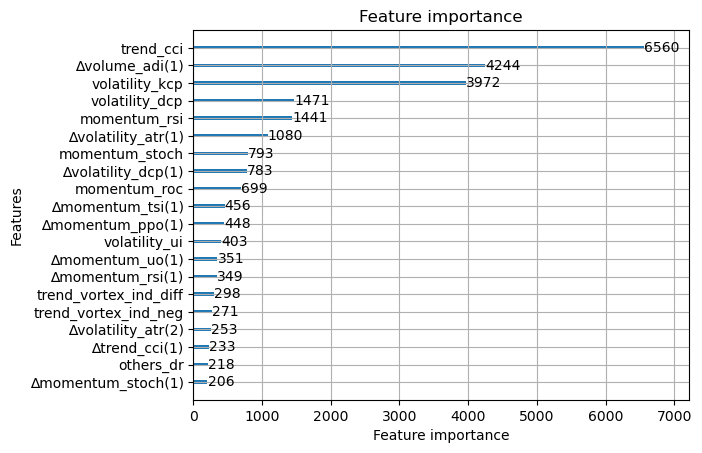

In [329]:
from lightgbm import plot_importance, plot_metric
plot_importance(clf, max_num_features=20)

<Axes: xlabel='Importance', ylabel='Feature'>

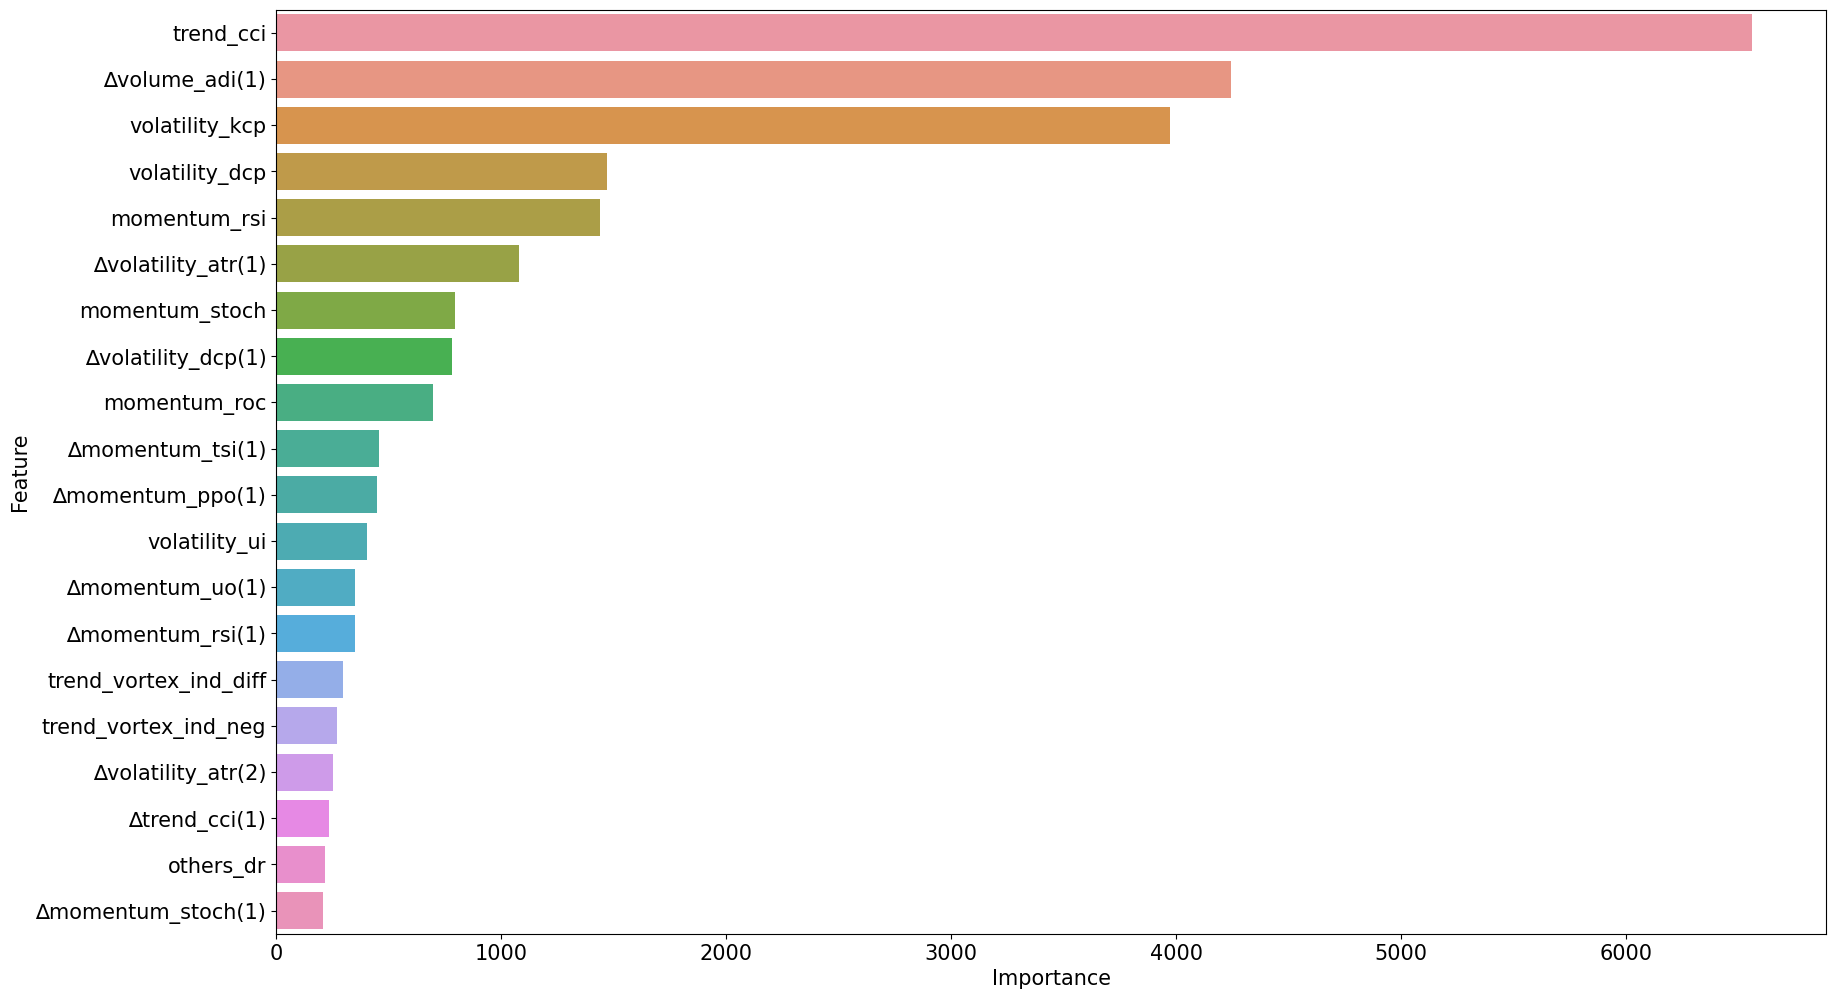

In [352]:
import seaborn as sns

fi = pd.DataFrame(clf.feature_importance(), index = clf.feature_name()).reset_index()
fi.columns = ['Feature', 'Importance']
top20fi = fi.sort_values(by='Importance', ascending = False).iloc[:20]

plt.figure(figsize = (20, 12))
plt.rc('font', size=15)  

sns.barplot(y='Feature', x='Importance', data = top20fi)

# Save Model

In [353]:
!pip install joblib

In [354]:
import joblib

filename = 'lgbm_model.pkl'
joblib.dump(clf, filename)

['lgbm_model.pkl']

In [355]:
load_clf = joblib.load(filename)